In [1]:
import os

import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
from tensorflow import keras

from src.data_utils import (
    ImageLoader,
    TripletsGenerator,
    plot_triplets,
    train_val_split,
)
from src.utils import (
    compute_val_dcg,
    make_callbacks,
    plot_history,
    save_params,
    save_submission,
    show_heatmap,
    triplet_loss,
)

InteractiveShell.ast_node_interactivity = "all"

In [2]:
class CFG:
    def __init__(
        self,
    ):
        self.seed = 39
        self.batch_size = 64
        self.img_size = (512, 81)
        self.n_channels = None
        self.fold = 0
        self.norm = False
        self.pos_label = 0
        self.emb_len = 1024
        self.kernel_size = 3
        self.act_fn = "relu"
        self.batch_norm = True
        self.n_epochs = 150
        self.center_crop = False
        self.input_shape = (
            self.img_size
            if self.n_channels is None
            else (*self.img_size, self.n_channels)
        )


cfg = CFG()

In [3]:
root_dir = "/app/_data/artist_data/"
mod_dir = f"/app/_data/artist_data/models/triplets_fold_{cfg.fold}/"
os.makedirs(mod_dir, exist_ok=True)

In [4]:
train = pd.read_csv(os.path.join(root_dir, "train_meta.tsv"), sep="\t")
test = pd.read_csv(os.path.join(root_dir, "test_meta.tsv"), sep="\t")

## train_val_split

In [5]:
train_df, val_df = train_val_split(df=train, fold=0, n_splits=8, seed=42)

## DataGenerator

In [6]:
train_gen = TripletsGenerator(
    df=train_df,
    data_loader=ImageLoader(
        target_size=cfg.img_size,
        augment=True,
        center_crop=cfg.center_crop,
        norm=cfg.norm,
        n_channels=cfg.n_channels,
    ),
    batch_size=cfg.batch_size,
    shuffle=True,
)
val_gen = TripletsGenerator(
    df=val_df,
    data_loader=ImageLoader(
        target_size=cfg.img_size,
        augment=True,
        center_crop=cfg.center_crop,
        norm=cfg.norm,
        n_channels=cfg.n_channels,
    ),
    batch_size=cfg.batch_size,
    shuffle=True,
)

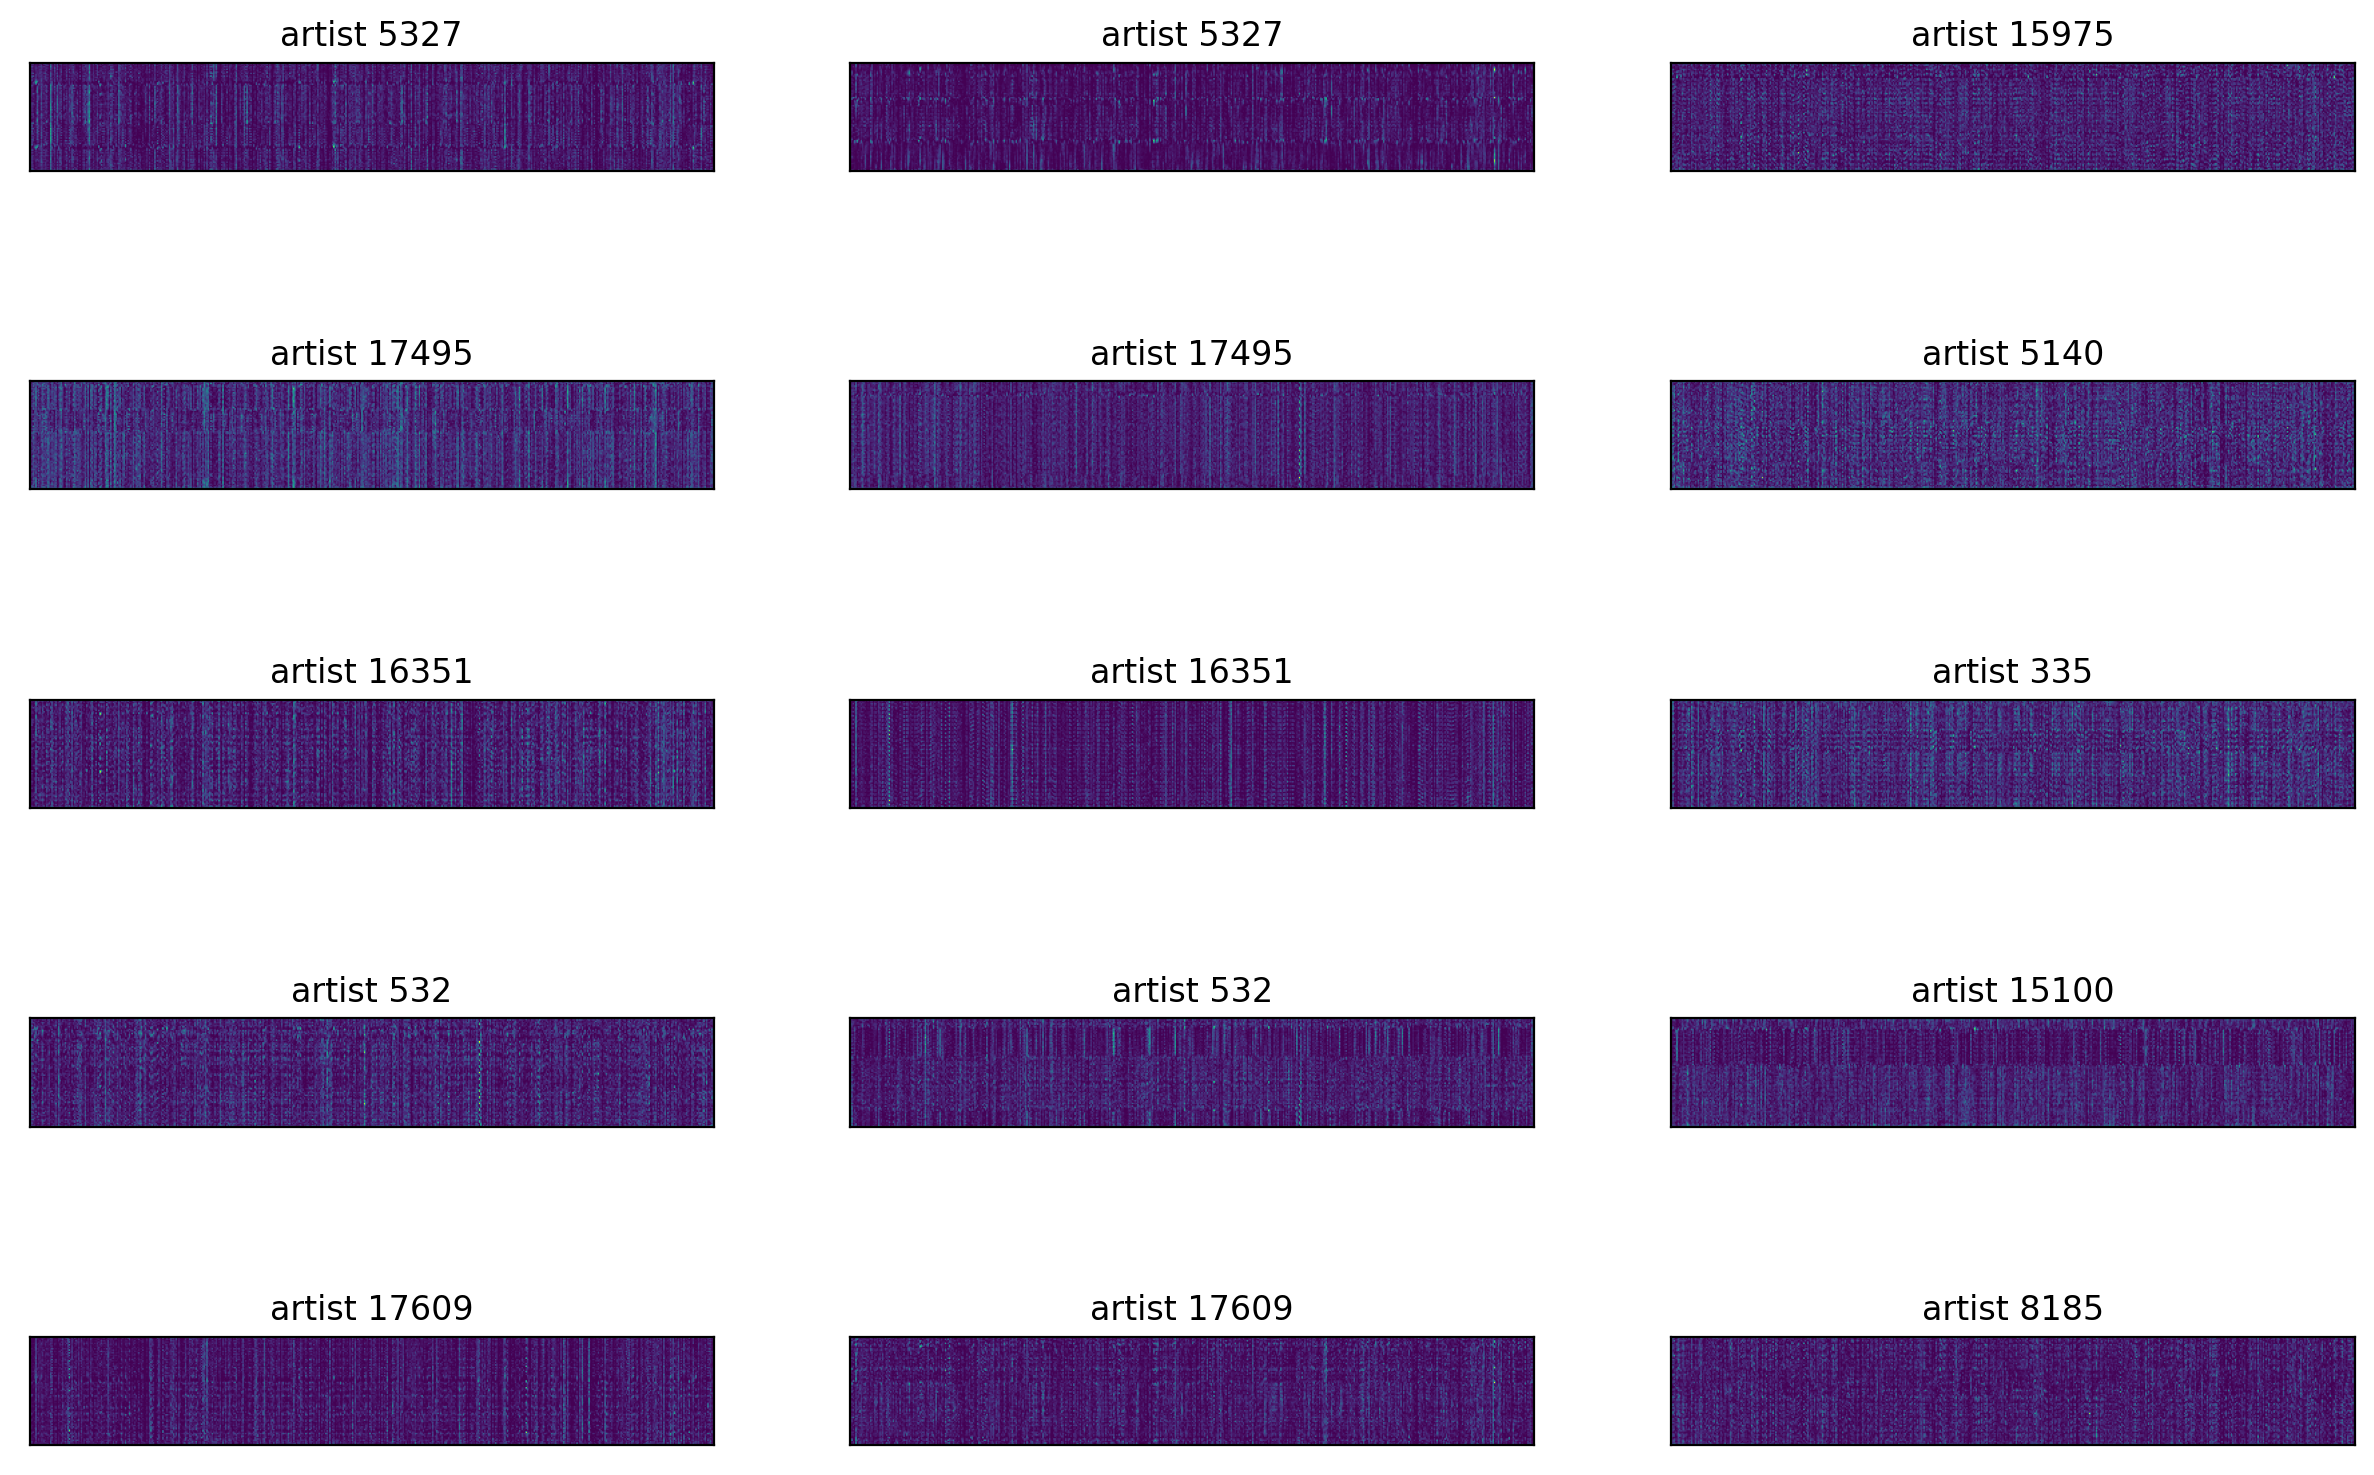

In [7]:
plot_triplets(train_gen, n_examples=5)

## Model

In [8]:
def embNet(cfg):
    input = keras.Input(shape=cfg.input_shape, dtype="float32")
    x = keras.layers.Conv1D(
        cfg.input_shape[1],
        cfg.kernel_size,
        activation=cfg.act_fn,
        name="Conv1D_1",
    )(input)

    x = keras.layers.Conv1D(
        filters=cfg.input_shape[1],
        kernel_size=cfg.kernel_size,
        activation=cfg.act_fn,
        name="Conv1D_2",
    )(x)
    x = keras.layers.AveragePooling1D(pool_size=2, name="avg_pool_1")(x)

    x = keras.layers.Conv1D(
        filters=cfg.input_shape[1],
        kernel_size=cfg.kernel_size,
        activation=cfg.act_fn,
        name="Conv1D_3",
    )(x)

    x = keras.layers.Conv1D(
        filters=cfg.input_shape[1],
        kernel_size=cfg.kernel_size,
        activation=cfg.act_fn,
        name="Conv1D_4",
    )(x)
    x = keras.layers.AveragePooling1D(pool_size=2, name="avg_pool_2")(x)
    x = keras.layers.Flatten(name="flatten")(x)
    x = keras.layers.Dense(cfg.emb_len, activation=None, name=f"dense_{cfg.emb_len}")(x)
    return keras.Model(inputs=input, outputs=x, name="embedding")


embedding_net = embNet(cfg)

In [9]:
def siamese_model(input_shape, embedding_net):
    input_anchor = keras.layers.Input(shape=input_shape, name="anchor")
    input_positive = keras.layers.Input(shape=input_shape, name="positive")
    input_negative = keras.layers.Input(shape=input_shape, name="negative")

    embedding_anchor = keras.layers.Reshape((1, -1))(embedding_net(input_anchor))
    embedding_positive = keras.layers.Reshape((1, -1))(embedding_net(input_positive))
    embedding_negative = keras.layers.Reshape((1, -1))(embedding_net(input_negative))

    output = keras.layers.concatenate(
        [embedding_anchor, embedding_positive, embedding_negative], axis=1
    )
    siamese_net = keras.models.Model(
        inputs=[input_anchor, input_positive, input_negative],
        outputs=output,
        name="siamese",
    )
    return siamese_net

In [10]:
siamese_net = siamese_model(
    input_shape=cfg.input_shape,
    embedding_net=embedding_net,
)

callbacks = make_callbacks(
    path=mod_dir, monitor="val_loss", mode="min", reduce_patience=3, stop_patience=13
)

siamese_net.compile(optimizer=keras.optimizers.Adam(0.005), loss=triplet_loss(0.5))

## Train

In [11]:
history = siamese_net.fit(
    x=train_gen,
    steps_per_epoch=train_gen.__len__(),
    validation_data=val_gen,
    callbacks=callbacks,
    epochs=cfg.n_epochs,
    use_multiprocessing=True,
    workers=10,
)

Epoch 1/150
252/252 [==============================] - ETA: 0s - loss: 0.2355
Epoch 1: val_loss improved from inf to 0.15110, saving model to /app/_data/artist_data/models/triplets_fold_0/best.h5
252/252 [==============================] - 52s 185ms/step - loss: 0.2355 - val_loss: 0.1511 - lr: 0.0050
Epoch 2/150
252/252 [==============================] - ETA: 0s - loss: 0.1473
Epoch 2: val_loss did not improve from 0.15110
252/252 [==============================] - 42s 158ms/step - loss: 0.1473 - val_loss: 0.1515 - lr: 0.0050
Epoch 3/150
252/252 [==============================] - ETA: 0s - loss: 0.1379
Epoch 3: val_loss improved from 0.15110 to 0.12861, saving model to /app/_data/artist_data/models/triplets_fold_0/best.h5
252/252 [==============================] - 41s 156ms/step - loss: 0.1379 - val_loss: 0.1286 - lr: 0.0050
Epoch 4/150
252/252 [==============================] - ETA: 0s - loss: 0.1302
Epoch 4: val_loss improved from 0.12861 to 0.12338, saving model to /app/_data/artist_

Process Keras_worker_ForkPoolWorker-1298:
Process Keras_worker_ForkPoolWorker-1300:
Process Keras_worker_ForkPoolWorker-1293:
Process Keras_worker_ForkPoolWorker-1291:
Process Keras_worker_ForkPoolWorker-1294:
Process Keras_worker_ForkPoolWorker-1292:
Process Keras_worker_ForkPoolWorker-1296:
Process Keras_worker_ForkPoolWorker-1295:
Process Keras_worker_ForkPoolWorker-1299:
Process Keras_worker_ForkPoolWorker-1297:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessi

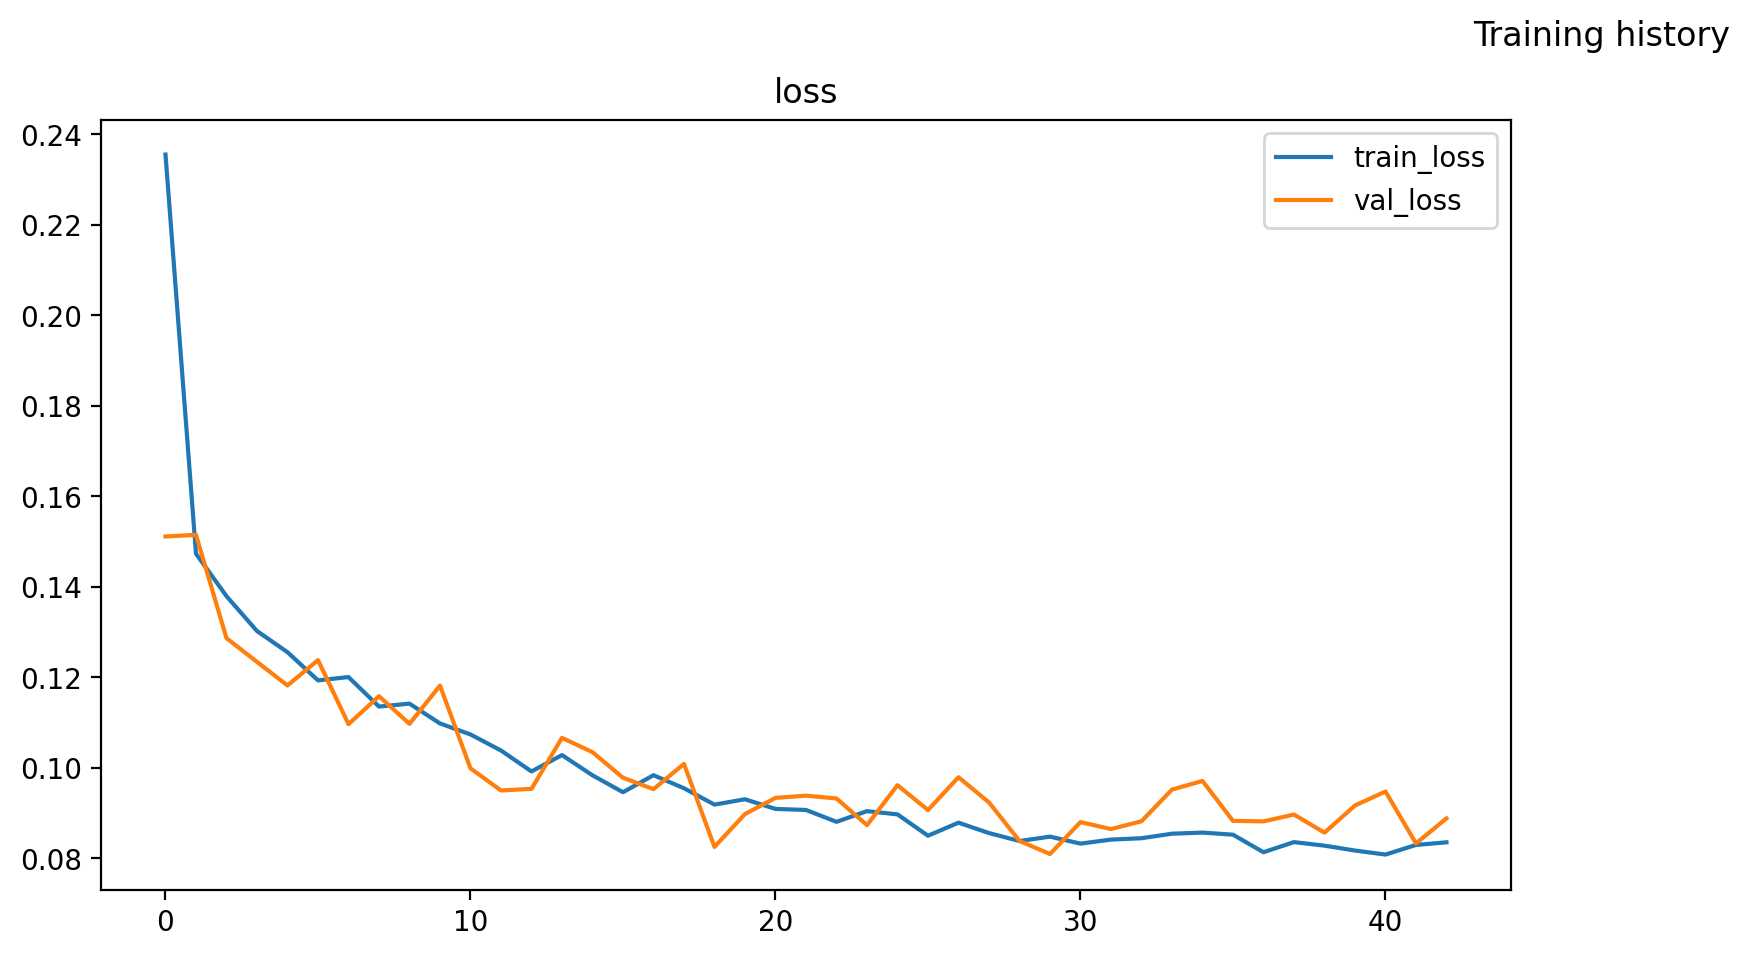

In [12]:
plot_history(history.history)

## Eval

In [13]:
emb_model = [x for x in siamese_net.layers if x.name == "embedding"][0]
compute_val_dcg(emb_model, val_df, cfg, "euclidean")

Making prediction
20744/20744 [==============================] - 53s 3ms/step

Computing ranked list


100% 20744/20744 [00:04<00:00, 4996.76it/s]
100% 20744/20744 [00:35<00:00, 578.75it/s]



Calculating NDCG


100% 20744/20744 [00:05<00:00, 3702.11it/s]


NDCG on val set = 0.26211


300/300 [==============================] - 1s 2ms/step


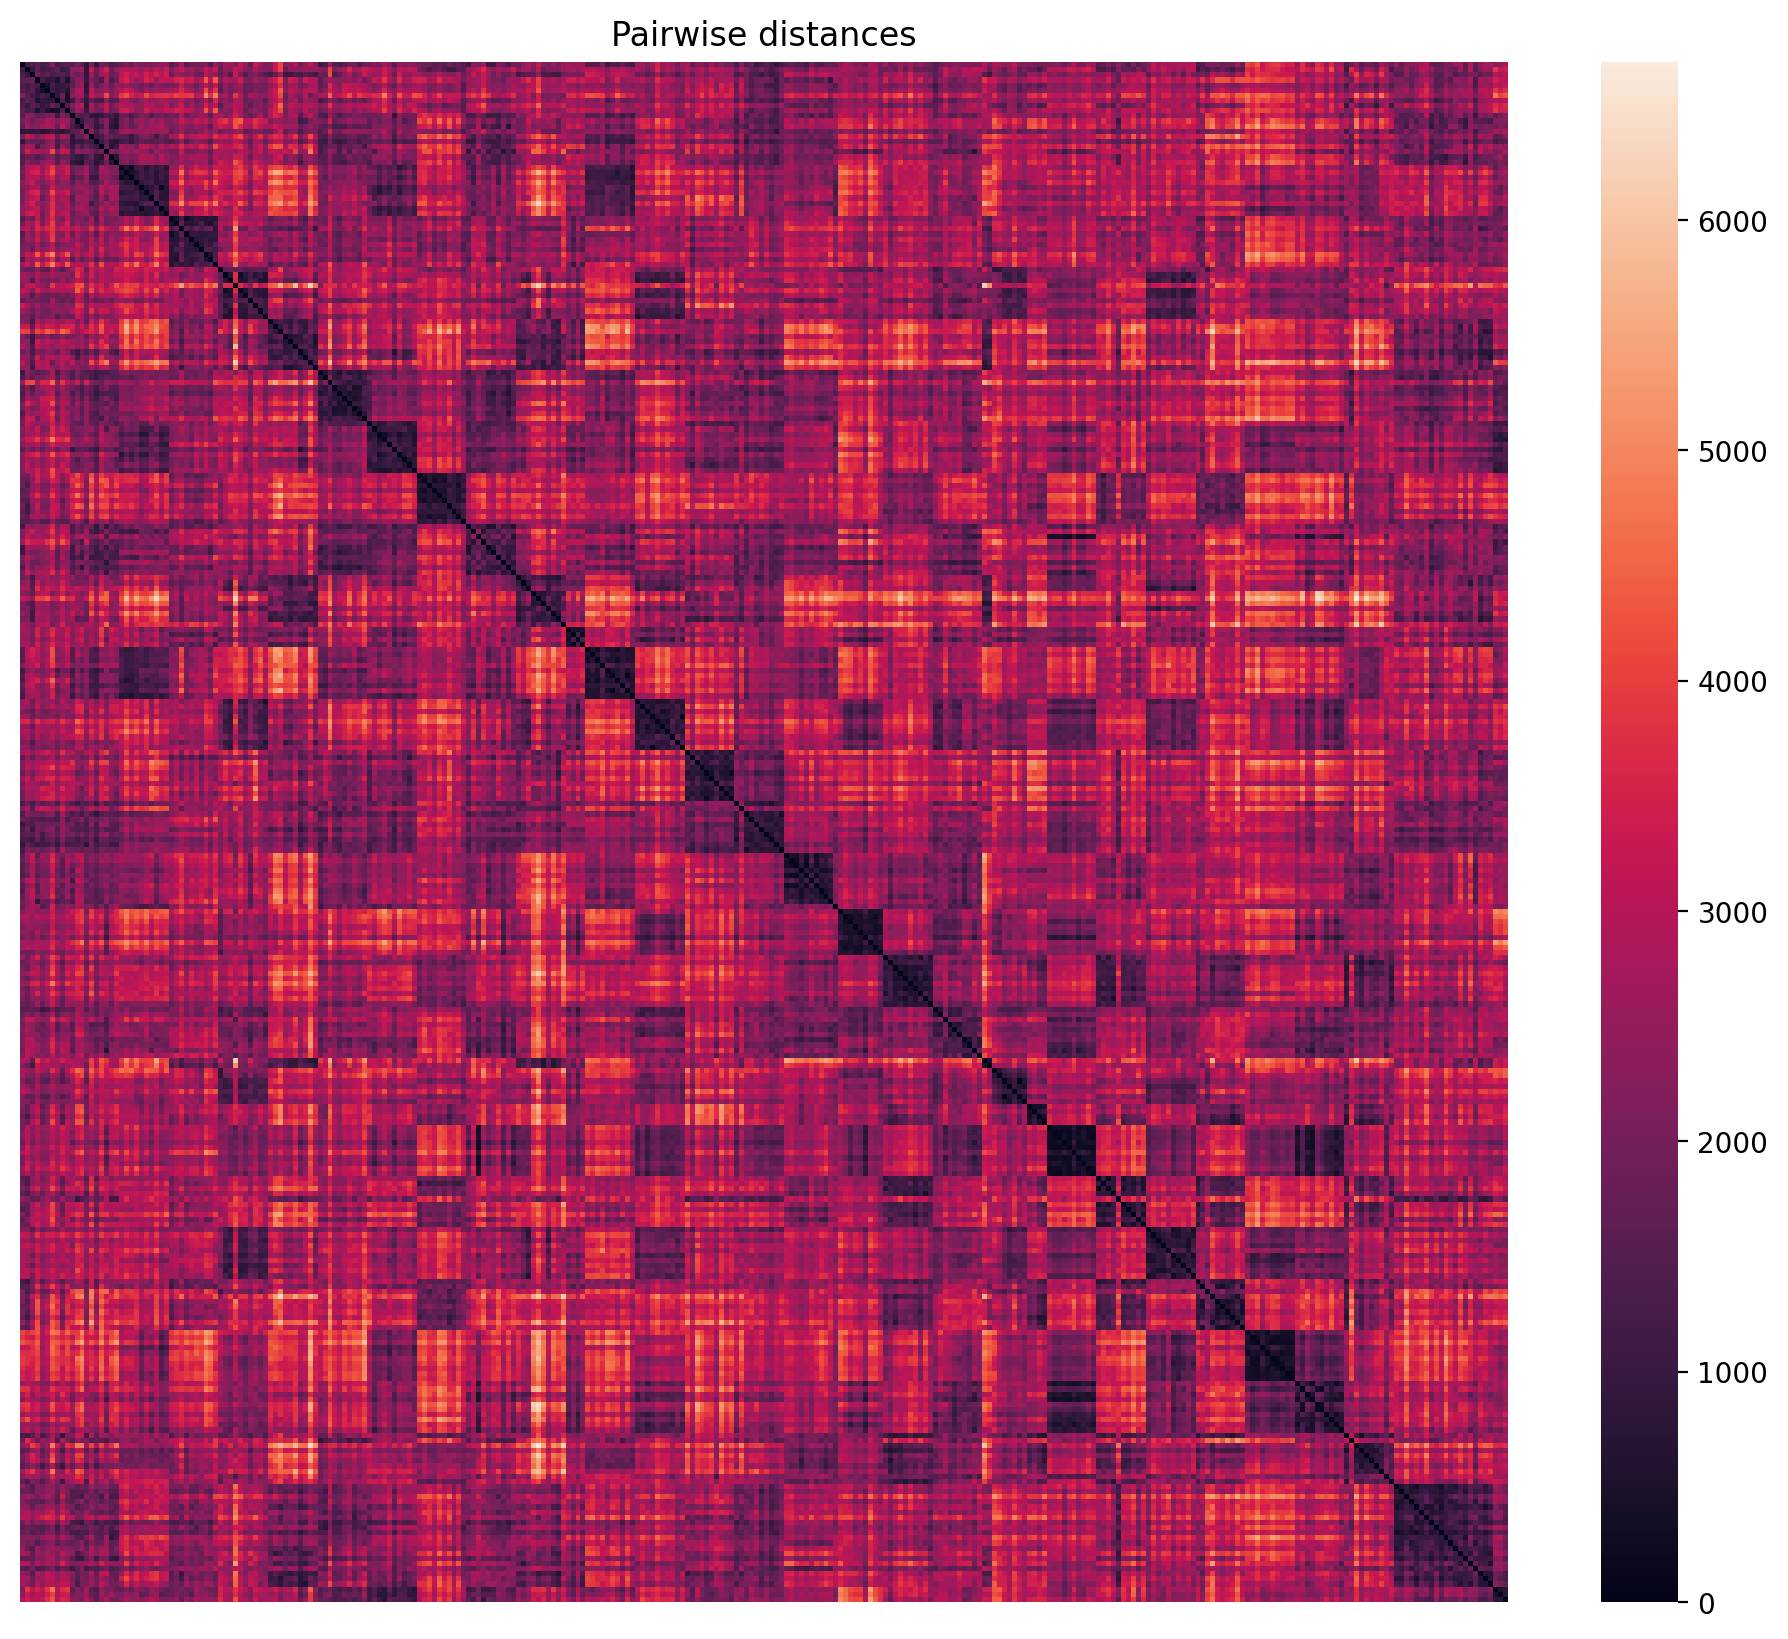

In [14]:
show_heatmap(val_df.sort_values("artistid").head(300), cfg, emb_model)

## Save model, history and params

In [15]:
save_params(
    mod_dir,
    emb_model,
    history,
    cfg,
    loss_name="TripletLoss",
    metric=None,
    triplets=True,
)


Min_loss = 0.0809049978852272, model saved to /app/_data/artist_data/models/triplets_fold_0/model_81.h5


## Test

In [16]:
save_submission(
    model=emb_model,
    test_df=test,
    cfg=cfg,
    submission_path=mod_dir,
    annoy_metric="angular",
    top_size=100,
    annoy_num_trees=256,
)

Making prediction
41377/41377 [==============================] - 105s 3ms/step

Computing ranked list


100% 41377/41377 [00:08<00:00, 4953.48it/s]
100% 41377/41377 [02:19<00:00, 295.91it/s]



Submission file saved to /app/_data/artist_data/models/triplets_fold_0/submission_100.txt
